In [126]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import tree
from sklearn.model_selection import GridSearchCV
from datetime import datetime
import nltk.classify.util
from nltk.classify import NaiveBayesClassifier
from nltk.corpus import movie_reviews
import textstat
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.tokenize import PunktSentenceTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.stem.snowball import SnowballStemmer
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer 
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing
from sklearn.decomposition import PCA
from  scipy.stats import chi2_contingency

In [191]:
#import data
hair_dryer_data=pd.read_csv('hair_dryer.tsv', sep='\t')
microwave_data=pd.read_csv('microwave.tsv', sep='\t')
pacifier_data=pd.read_csv('pacifier.tsv', sep='\t')
alldata=[]
alldata.append(hair_dryer_data)
alldata.append(microwave_data)
alldata.append(pacifier_data)

In [192]:
#data preprocessing
for i in range(3):
    alldata[i]['verified_purchase']=alldata[i]['verified_purchase'].str.upper()
    alldata[i]['verified_purchase']=(alldata[i]['verified_purchase']=='Y')+0
    alldata[i]['vine']=alldata[i]['vine'].str.upper()
    alldata[i]['vine']=(alldata[i]['vine']=='Y')+0
# review feature extraction    
    alldata[i]['fkre']=[textstat.flesch_reading_ease(review)if type(review)==str else 0 for review in alldata[i]['review_body']]
    alldata[i]['syllablenum']=[textstat.syllable_count(review)if type(review)==str else 0 for review in alldata[i]['review_body']]
    alldata[i]['wordnum']=[textstat.lexicon_count(review)if type(review)==str else 0 for review in alldata[i]['review_body']]
    alldata[i]['sentencenum']=[textstat.sentence_count(review)if type(review)==str else 0 for review in alldata[i]['review_body']]
    alldata[i]['helpful_rate']=alldata[i]['helpful_votes']/alldata[i]['total_votes']

In [193]:
analyzer=SentimentIntensityAnalyzer() 
for i in range(3):
    print('loading...')
    alldata[i]['pos']=[analyzer.polarity_scores(text)['pos'] if type(text)==str else 0.33 for text in alldata[i]['review_body']]
    alldata[i]['neu']=[analyzer.polarity_scores(text)['neu'] if type(text)==str else 0.33 for text in alldata[i]['review_body']]
    alldata[i]['neg']=[analyzer.polarity_scores(text)['neg'] if type(text)==str else 0.33 for text in alldata[i]['review_body']]

loading...
loading...
loading...


In [194]:
#feature categorize
for i in range(3):
    if i==0:
        alldata[i]['trans_rating']=[1 if num==5 else 0 for num in alldata[i]['star_rating']]
    else: 
        if i==1:   
            alldata[i]['trans_rating']=[1 if num>3 else 0 for num in alldata[i]['star_rating']]
        else: 
            alldata[i]['trans_rating']=[1 if num==5 else 0 for num in alldata[i]['star_rating']]
    alldata[i]['trans_helpful']=[1 if num>0.5 else 0 for num in alldata[i]['helpful_rate']]

In [195]:
#set onfounding parametres
for i in range(3):
    alldata[i]['rela_pos']=(alldata[i]['pos']>alldata[i]['neg'])+0
    alldata[i]['rela_neg']=1-alldata[i]['rela_pos']
    alldata[i]['helpful*neg']=alldata[i]['trans_helpful']*(1-alldata[i]['rela_pos'])
    alldata[i]['helpful*pos']=alldata[i]['trans_helpful']*alldata[i]['rela_pos']
    alldata[i]['nothelp*neg']=(1-alldata[i]['trans_helpful'])*(1-alldata[i]['rela_pos'])
    alldata[i]['nothelp*pos']=(1-alldata[i]['trans_helpful'])*alldata[i]['rela_pos']  

In [7]:
#data preprocessing
for data in alldata:
    poslist=[]
    neglist=[]
    for review in data['review_body']: 
        posnum=0
        negnum=0
        if type(review)==str:
            for word in nltk.word_tokenize(review):
                a=analyzer.polarity_scores(word)
                if a['pos']==1:
                    posnum+=1
                if a['neg']==1:
                    negnum+=1
        poslist.append(posnum)  
        neglist.append(negnum)
    data['posnum']=poslist
    data['negnum']=neglist 
    data['pos-negnum']=data['posnum']-data['negnum']

In [8]:
#data preprocessing
for i in range(3):
    alldata[i].fillna(0,inplace=True)
    #alldata[i].drop(columns=['marketplace', 'customer_id', 'review_id', 'product_id',
     #  'product_parent', 'product_title', 'product_category'],inplace=True)
    alldata[i]['weighted_pos']=alldata[i]['helpful_rate']*alldata[i]['rela_pos']
    alldata[i]['weighted_neg']=alldata[i]['helpful_rate']*alldata[i]['rela_neg']

In [9]:
Xtrain=alldata[2][['pos','neu','neg','fkre','wordnum','vine','verified_purchase','trans_rating']]
ytrain=alldata[2]['trans_helpful']
scaler = preprocessing.StandardScaler().fit(Xtrain)
Xtrain=scaler.transform(Xtrain)

In [204]:
allall=pd.DataFrame()
for data in alldata:
    allall=pd.concat([allall,data])

In [205]:
pd.crosstab(allall['rela_pos'],allall['star_rating'])

star_rating,1,2,3,4,5
rela_pos,,,,,
0,1634,819,882,676,1625
1,992,877,1677,4436,18406


In [208]:
chi2_contingency(pd.crosstab(allall['rela_pos'],allall['star_rating']))

(6520.180419435507,
 0.0,
 4,
 array([[  462.15763178,   298.4841369 ,   450.36610042,   899.67624282,
          3525.31588808],
        [ 2163.84236822,  1397.5158631 ,  2108.63389958,  4212.32375718,
         16505.68411192]]))

In [213]:
pd.crosstab(allall['trans_helpful'],allall['star_rating']).div(pd.crosstab(allall['trans_helpful'],allall['star_rating']).sum(1),axis=0)

star_rating,1,2,3,4,5
trans_helpful,,,,,
0,0.062160,0.046398,0.077075,0.158907,0.655460
1,0.150201,0.075516,0.089649,0.162117,0.522516


In [214]:
pd.crosstab(allall['trans_helpful'],allall['trans_rating']).div(pd.crosstab(allall['trans_helpful'],allall['trans_rating']).sum(1),axis=0)

trans_rating,0,1
trans_helpful,,
0,0.338211,0.661789
1,0.457669,0.542331


In [209]:
chi2_contingency(pd.crosstab(allall['trans_helpful'],allall['star_rating']))

(787.3435160197104,
 4.234126854578258e-169,
 4,
 array([[ 2034.19878841,  1313.78566075,  1982.29805771,  3959.94828878,
         15516.76920435],
        [  591.80121159,   382.21433925,   576.70194229,  1152.05171122,
          4514.23079565]]))

In [207]:
pd.crosstab(allall['rela_pos'],allall['trans_helpful'])

trans_helpful,0,1
rela_pos,,
0,4159,1477
1,20648,5740


In [212]:
chi2_contingency(pd.crosstab(allall['rela_pos'],allall['trans_helpful']))

(52.524625532975094,
 4.248871058382662e-13,
 1,
 array([[ 4365.85848114,  1270.14151886],
        [20441.14151886,  5946.85848114]]))

In [10]:
param_grid = { 'C': [0.001,0.01,0.1,1,10,100,1000,10000]}
mytree=LogisticRegression()
clf=GridSearchCV(mytree, param_grid, cv=5,scoring='roc_auc')
clf.fit(Xtrain,ytrain)
pd.DataFrame(clf.cv_results_)

C:\Users\86180\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\86180\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\86180\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\86180\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\86180\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.015577,0.001832,0.002965,0.002460,0.001,{'C': 0.001},0.753668,0.751755,0.687213,0.713347,0.712617,0.723726,0.025482,1
1,0.018223,0.002177,0.001601,0.000489,0.01,{'C': 0.01},0.747195,0.745730,0.688326,0.710895,0.705226,0.719480,0.023259,2
2,0.016628,0.001206,0.001797,0.000398,0.1,{'C': 0.1},0.744859,0.743271,0.688558,0.709911,0.702947,0.717915,0.022445,3
3,0.020370,0.002612,0.002447,0.000434,1,{'C': 1},0.744554,0.742937,0.688597,0.709747,0.702661,0.717705,0.022337,4
4,0.022698,0.003126,0.002251,0.000389,10,{'C': 10},0.744537,0.742891,0.688592,0.709752,0.702623,0.717685,0.022328,5
5,0.020957,0.002141,0.002027,0.000066,100,{'C': 100},0.744530,0.742864,0.688596,0.709752,0.702619,0.717677,0.022320,8
6,0.022870,0.001480,0.001843,0.000379,1000,{'C': 1000},0.744530,0.742864,0.688594,0.709752,0.702621,0.717678,0.022320,7
7,0.023148,0.003556,0.002399,0.001018,10000,{'C': 10000},0.744530,0.742865,0.688594,0.709752,0.702621,0.717678,0.022320,6


In [11]:
clf3=LogisticRegression(C=0.001).fit(Xtrain,ytrain)
clf3.coef_

C:\Users\86180\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


array([[-0.10646686,  0.09849678,  0.04826202, -0.15224923,  0.25702749,
        -0.00032852, -0.12791423, -0.04909023]])

In [12]:
Xtrain=alldata[2][['pos','neu','neg','fkre','wordnum','vine','verified_purchase','trans_rating']]
ytrain=alldata[2]['trans_helpful']

In [13]:
param_grid2 = { 'max_depth': [1,2,3,4,5,6]}
mytree2=tree.DecisionTreeClassifier()
clf2=GridSearchCV(mytree2, param_grid2, cv=5,scoring='roc_auc')
clf2.fit(Xtrain,ytrain)
pd.DataFrame(clf2.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.006454,0.000450,0.001800,0.000400,1,{'max_depth': 1},0.684569,0.675523,0.670902,0.633821,0.620338,0.657035,0.025210,6
1,0.010182,0.000911,0.002448,0.000477,2,{'max_depth': 2},0.731014,0.745016,0.746695,0.655265,0.655085,0.706622,0.042350,5
2,0.012952,0.000548,0.001600,0.000490,3,{'max_depth': 3},0.732242,0.756640,0.749849,0.680174,0.677631,0.719313,0.033946,1
3,0.015226,0.000520,0.001883,0.000469,4,{'max_depth': 4},0.732200,0.752137,0.723150,0.689857,0.675701,0.714615,0.027990,3
4,0.018780,0.000814,0.002055,0.000114,5,{'max_depth': 5},0.741334,0.755515,0.716697,0.686797,0.675045,0.715085,0.030756,2
5,0.021707,0.000486,0.002200,0.000400,6,{'max_depth': 6},0.734644,0.752322,0.717488,0.677556,0.677160,0.711841,0.030229,4


Text(0.5, 1.0, 'paci_helpful_tree')

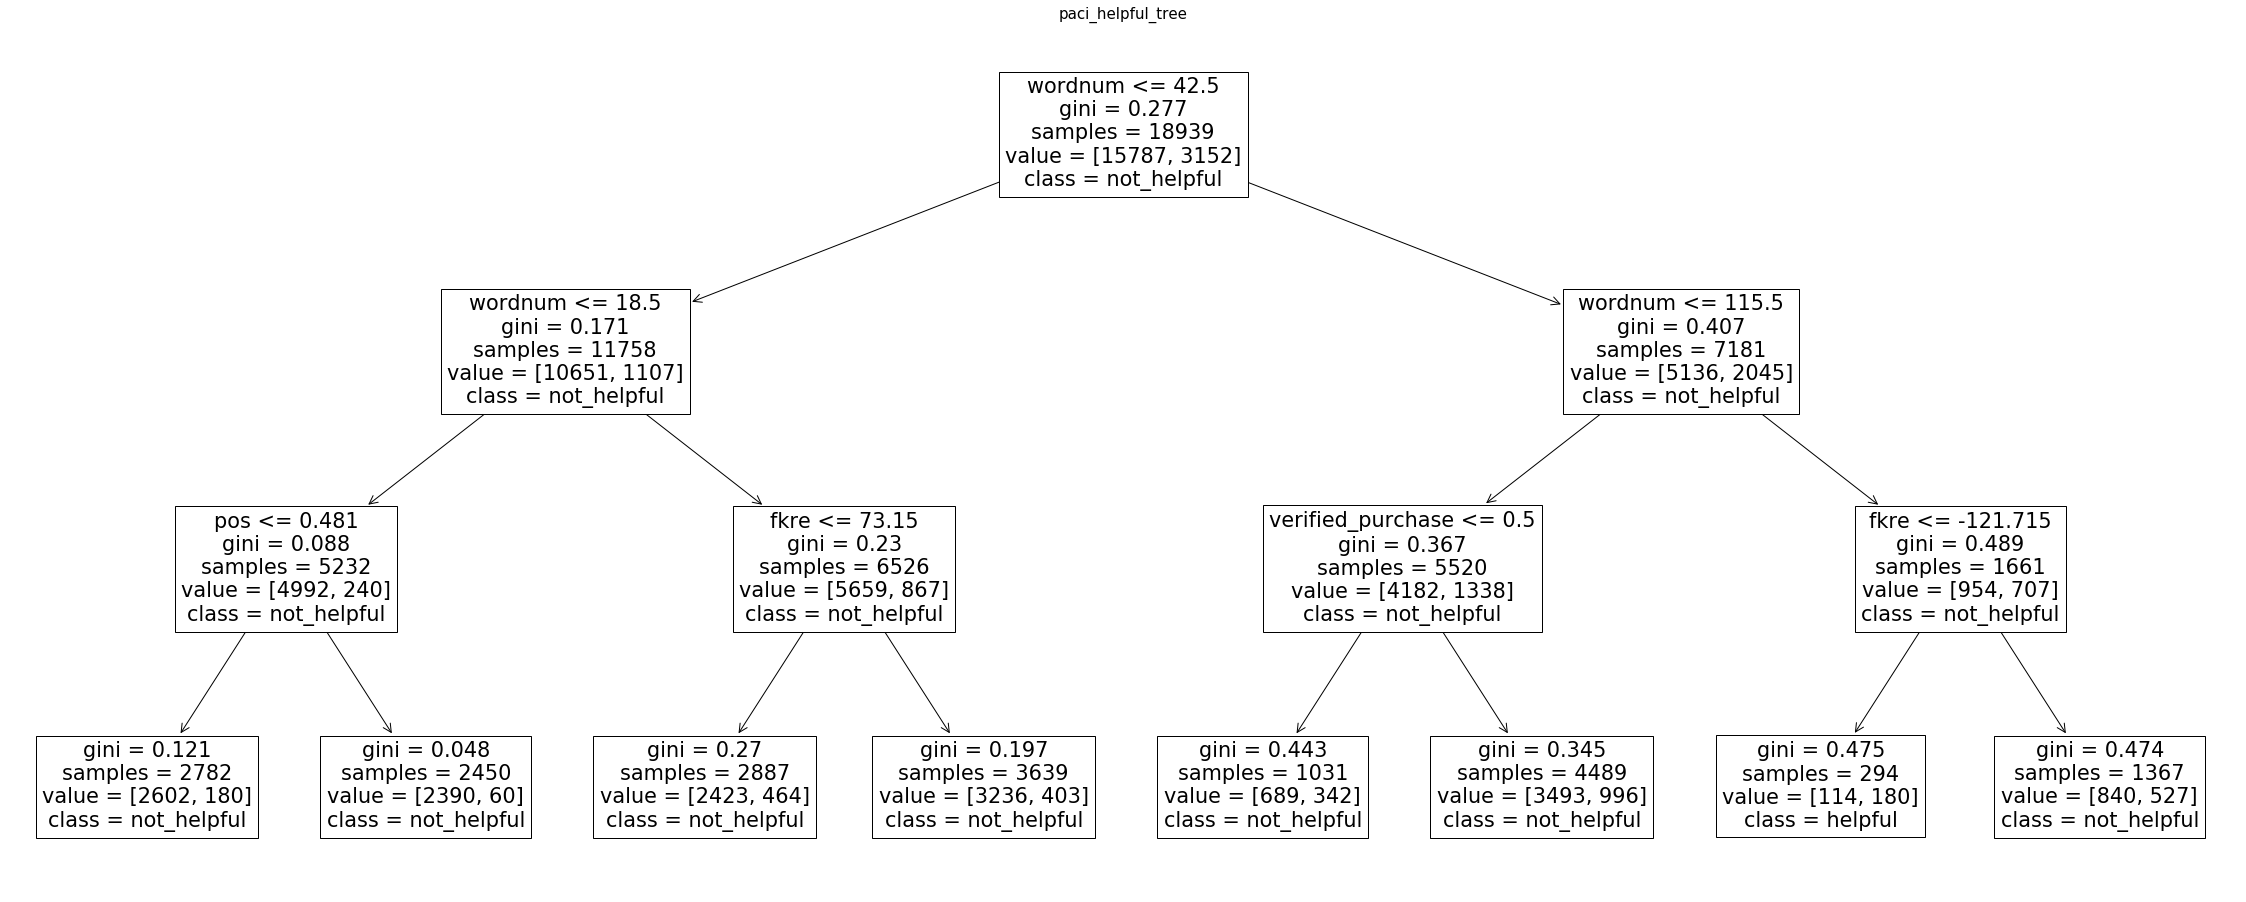

In [14]:
clf3=tree.DecisionTreeClassifier(max_depth=3)
clf3.fit(Xtrain,ytrain)
fig=plt.figure(figsize=(40,16))
ax=fig.add_subplot(1,1,1)
tree.plot_tree(clf3,ax=ax,feature_names=['pos','neu','neg','fkre','wordnum','vine','verified_purchase','trans_rating'],
               class_names=['not_helpful','helpful'])
plt.title('paci_helpful_tree',fontsize=15)

In [15]:
#groupby product id
all_group=[]
all_group.append(hair_dryer_data.groupby('product_id'))
all_group.append(microwave_data.groupby('product_id'))
all_group.append(pacifier_data.groupby('product_id'))

In [16]:
all_group_detail=[[],[],[]]
for i in range(3):
    for _,group in all_group[i]:
        all_group_detail[i].append(group)
    all_group_detail[i].sort(key=len,reverse=True)

In [17]:
for products in all_group_detail:
    for product in products:
        product['days']=[(datetime.strptime(date,'%m/%d/%Y')-datetime.strptime(product['review_date'].values[-1:][0],'%m/%d/%Y')).days
            for date in product['review_date']]

In [18]:
all_info=[]
for i,group in enumerate(all_group):
    product_count=all_group[i].count().sort_values(by=['star_rating'],ascending=False)
    products_info=all_group[i].mean().loc[product_count.index]
    products_info['counts']=product_count['star_rating']
    products_info=products_info[products_info['counts']>=10]
    products_info['days']=[product['days'].max() for product in all_group_detail[i][0:len(products_info['counts']>=10)]]
    products_info['count_per_day']=products_info['counts']/products_info['days']
    products_info['helpful_rate']=products_info['helpful_votes']/products_info['total_votes']
    products_info['successful']= (products_info['count_per_day']>=products_info['count_per_day'].quantile(0.75))+0
    all_info.append(products_info)

In [19]:
arima_group=[[],[],[]]
for i in range(3):
    for group in all_group_detail[i]:
        arima_group[i].append(group[['star_rating','helpful_rate','trans_rating','trans_helpful','weighted_pos','weighted_neg']])

In [20]:
pcares=[[],[],[]]
post_group=[[],[],[]]
for i,groups in enumerate(arima_group):
    for group in groups:
        if group.shape[0]>4:
            Xtrain=group.values
            pca_digits = PCA(n_components=4)
            scaler = preprocessing.StandardScaler().fit(Xtrain)
            Xtrain=scaler.transform(Xtrain)
            Xtrain = pca_digits.fit_transform(Xtrain)
            100*pca_digits.explained_variance_ratio_
            pcares[i].append(pca_digits)
            post_group[i].append(Xtrain)
        else:
            pcares[i].append(0)
            post_group[i].append(0)

C:\Users\86180\Anaconda3\lib\site-packages\sklearn\decomposition\pca.py:447: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
C:\Users\86180\Anaconda3\lib\site-packages\sklearn\decomposition\pca.py:447: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
C:\Users\86180\Anaconda3\lib\site-packages\sklearn\decomposition\pca.py:447: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
C:\Users\86180\Anaconda3\lib\site-packages\sklearn\decomposition\pca.py:447: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
C:\Users\86180\Anaconda3\lib\site-packages\sklearn\decomposition\pca.py:447: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
C:\Users\86180\Anaco

In [180]:
regar=post_group[0][4][:,0]

In [113]:
post_group[0][3]

array([[-0.55267873,  2.45265722, -0.84232547, -1.05404995],
       [ 3.61385774,  1.08001297, -1.36370848, -0.42906603],
       [-0.7306666 ,  1.39164528, -0.54801144,  0.09320466],
       ...,
       [ 3.20004934, -1.81984489, -0.31676833, -0.09589945],
       [ 2.90439418, -1.74970109, -0.23478937, -0.09268832],
       [ 3.42156261,  0.57401508, -1.18790821,  0.14568324]])

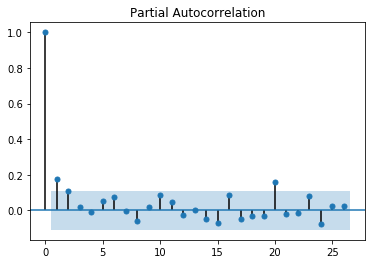

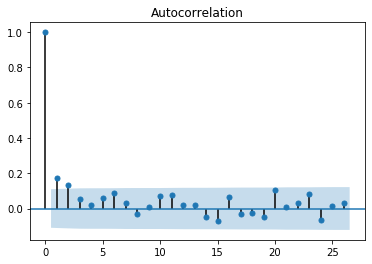

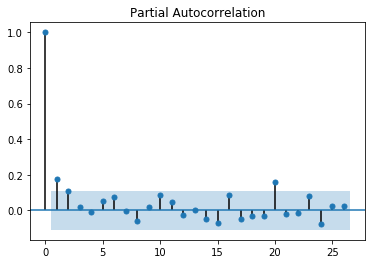

In [181]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(regar)
plot_pacf(regar)

In [108]:
from statsmodels.tsa.stattools import adfuller
adfuller(regar)
from statsmodels.stats.diagnostic import acorr_ljungbox
print(u'差分序列的白噪声检验结果：',acorr_ljungbox(regar, lags= 1))

差分序列的白噪声检验结果： (array([8.87929507]), array([0.00288423]))


In [183]:
import statsmodels.api as sm
model=sm.tsa.ARIMA(regar,(3,0,3)).fit()
model.summary2()

C:\Users\86180\Anaconda3\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


<class 'statsmodels.iolib.summary2.Summary'>
"""
                           Results: ARMA
===================================================================
Model:              ARMA             BIC:                 1284.2306
Dependent Variable: y                Log-Likelihood:      -619.03  
Date:               2020-03-10 02:23 Scale:               1.0000   
No. Observations:   321              Method:              css-mle  
Df Model:           7                Sample:              0        
Df Residuals:       314                                   1        
Converged:          1.0000           S.D. of innovations: 1.654    
No. Iterations:     51.0000          HQIC:                1266.106 
AIC:                1254.0591                                      
---------------------------------------------------------------------
            Coef.    Std.Err.      t       P>|t|     [0.025    0.975]
---------------------------------------------------------------------
const       0.0119     0.1489     0.0800   0.9363   -0.2799    0.3037
ar.L1.y     1.4864     0.1557     9.5488   0.0000    1.1813    1.7915
ar.L2.y    -1.5346     0.1105   -13.8829   0.0000   -1.7513   -1.3180
ar.L3.y     0.7773     0.1492     5.2093   0.0000    0.4848    1.0697
ma.L1.y    -1.3417     0.1847    -7.2635   0.0000   -1.7038   -0.9797
ma.L2.y     1.4501     0.1217    11.9154   0.0000    1.2115    1.6886
ma.L3.y    -0.6699     0.1832    -3.6565   0.0003   -1.0290   -0.3108
----------------------------------------------------------------------------
                Real           Imaginary          Modulus          Frequency
----------------------------------------------------------------------------
AR.1           0.3539            -0.9437           1.0079            -0.1929
AR.2           0.3539             0.9437           1.0079             0.1929
AR.3           1.2665            -0.0000           1.2665            -0.0000
MA.1           0.3359            -0.9419           1.0000            -0.1955
MA.2           0.3359             0.9419           1.0000             0.1955
MA.3           1.4927            -0.0000           1.4927            -0.0000
===================================================================

"""

In [25]:
for data in alldata:
    Xtrain=data[['star_rating', 'helpful_votes', 'total_votes', 'vine',
       'verified_purchase', 'fkre','helpful_rate', 'pos', 'neu', 'neg', 'trans_rating', 
        'trans_helpful','rela_pos', 'helpful*neg', 'helpful*pos', 'nothelp*neg', 
        'nothelp*pos','rela_neg', 'posnum', 'negnum', 'pos-negnum'
       ]]

In [33]:
pcadf=pd.DataFrame(columns=all_info[0].columns,index=['hair0','micro0','paci0','hair1','micro1','paci1','hair2','micro2','paci2','hair3','micro3','paci3'])

In [35]:
all_info[2].fillna(0,inplace=True)
pcares=[]
for info in all_info:
    Xtrain=info.values
    pca_digits = PCA(n_components=16)
    scaler = preprocessing.StandardScaler().fit(Xtrain)
    Xtrain=scaler.transform(Xtrain)
    Xtrain = pca_digits.fit_transform(Xtrain)
    100*pca_digits.explained_variance_ratio_
    pcares.append(pca_digits)

In [36]:
for i in range(4):
    pcadf.loc['hair{}'.format(i)]=pcares[0].components_[i]<0
    pcadf.loc['micro{}'.format(i)]=pcares[1].components_[i]<0
    pcadf.loc['paci{}'.format(i)]=pcares[2].components_[i]<0

In [37]:
pcadf.to_excel('2c.xlsx')

In [38]:
all_star_review=[]
for groups in all_group_detail:
    part_star_review=[]
    for group in groups:
        if group.shape[0]>5:
            star_review=group[['pos','neu','neg','rela_pos']][:-5]
            for i in range(5):
                if i!=4:
                    star_review['back{}'.format(i+1)]=group['trans_rating'].values[i+1:i-4]
                else:
                    star_review['back{}'.format(i+1)]=group['trans_rating'].values[i+1:]
            star_review['deviation']=(star_review['back1']+star_review['back2']+star_review['back3']+star_review['back4']+star_review['back5'])/5\
                -group['trans_rating'].mean()
        part_star_review.append(star_review)
    all_star_review.append(part_star_review)

In [39]:
star_review_all=pd.DataFrame()
for part_star_review in all_star_review:
    for star_review in part_star_review:
        star_review_all=pd.concat([star_review_all,star_review])

In [40]:
Xtrain=star_review_all[['back1', 'back2', 'back3', 'back4', 'back5','deviation']]
ytrain=star_review_all['rela_pos']

In [41]:
scaler = preprocessing.StandardScaler().fit(Xtrain)
Xtrain=scaler.transform(Xtrain)

In [42]:
param_grid6 = {'max_depth': [1,2,3,4,5,6]}
mytree6=tree.DecisionTreeClassifier()
clf6=GridSearchCV(mytree6, param_grid6, cv=5,scoring='roc_auc')
clf6.fit(Xtrain,ytrain)
pd.DataFrame(clf6.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.004873,0.000678,0.002185,0.001158,1,{'max_depth': 1},0.510557,0.543567,0.468286,0.560971,0.700662,0.556801,0.078559,6
1,0.006088,0.000594,0.001629,0.000516,2,{'max_depth': 2},0.511792,0.546218,0.464456,0.617299,0.884106,0.604758,0.148277,5
2,0.007398,0.000795,0.002062,0.001107,3,{'max_depth': 3},0.518438,0.534116,0.436583,0.631400,0.941722,0.612433,0.175875,3
3,0.008861,0.000729,0.002107,0.000563,4,{'max_depth': 4},0.504773,0.527499,0.472255,0.641004,0.974834,0.624052,0.184338,2
4,0.010064,0.000892,0.001744,0.000486,5,{'max_depth': 5},0.499888,0.543860,0.486440,0.638668,0.988079,0.631366,0.186129,1
5,0.012047,0.000744,0.002604,0.000793,6,{'max_depth': 6},0.487149,0.529507,0.406076,0.624542,0.990066,0.607447,0.203841,4


[Text(1674.0, 1245.75, 'back2 <= 0.5\ngini = 0.24\nsamples = 27031\nvalue = [3777, 23254]\nclass = rela_pos'),
 Text(837.0, 1019.25, 'deviation <= 0.065\ngini = 0.334\nsamples = 7456\nvalue = [1581, 5875]\nclass = rela_pos'),
 Text(418.5, 792.75, 'back5 <= 0.5\ngini = 0.321\nsamples = 6287\nvalue = [1261, 5026]\nclass = rela_pos'),
 Text(209.25, 566.25, 'back3 <= 0.5\ngini = 0.352\nsamples = 2979\nvalue = [680, 2299]\nclass = rela_pos'),
 Text(104.625, 339.75, 'deviation <= -0.068\ngini = 0.39\nsamples = 1471\nvalue = [390, 1081]\nclass = rela_pos'),
 Text(52.3125, 113.25, 'gini = 0.371\nsamples = 1358\nvalue = [334, 1024]\nclass = rela_pos'),
 Text(156.9375, 113.25, 'gini = 0.5\nsamples = 113\nvalue = [56, 57]\nclass = rela_pos'),
 Text(313.875, 339.75, 'deviation <= 0.053\ngini = 0.311\nsamples = 1508\nvalue = [290, 1218]\nclass = rela_pos'),
 Text(261.5625, 113.25, 'gini = 0.316\nsamples = 1462\nvalue = [288, 1174]\nclass = rela_pos'),
 Text(366.1875, 113.25, 'gini = 0.083\nsamples 

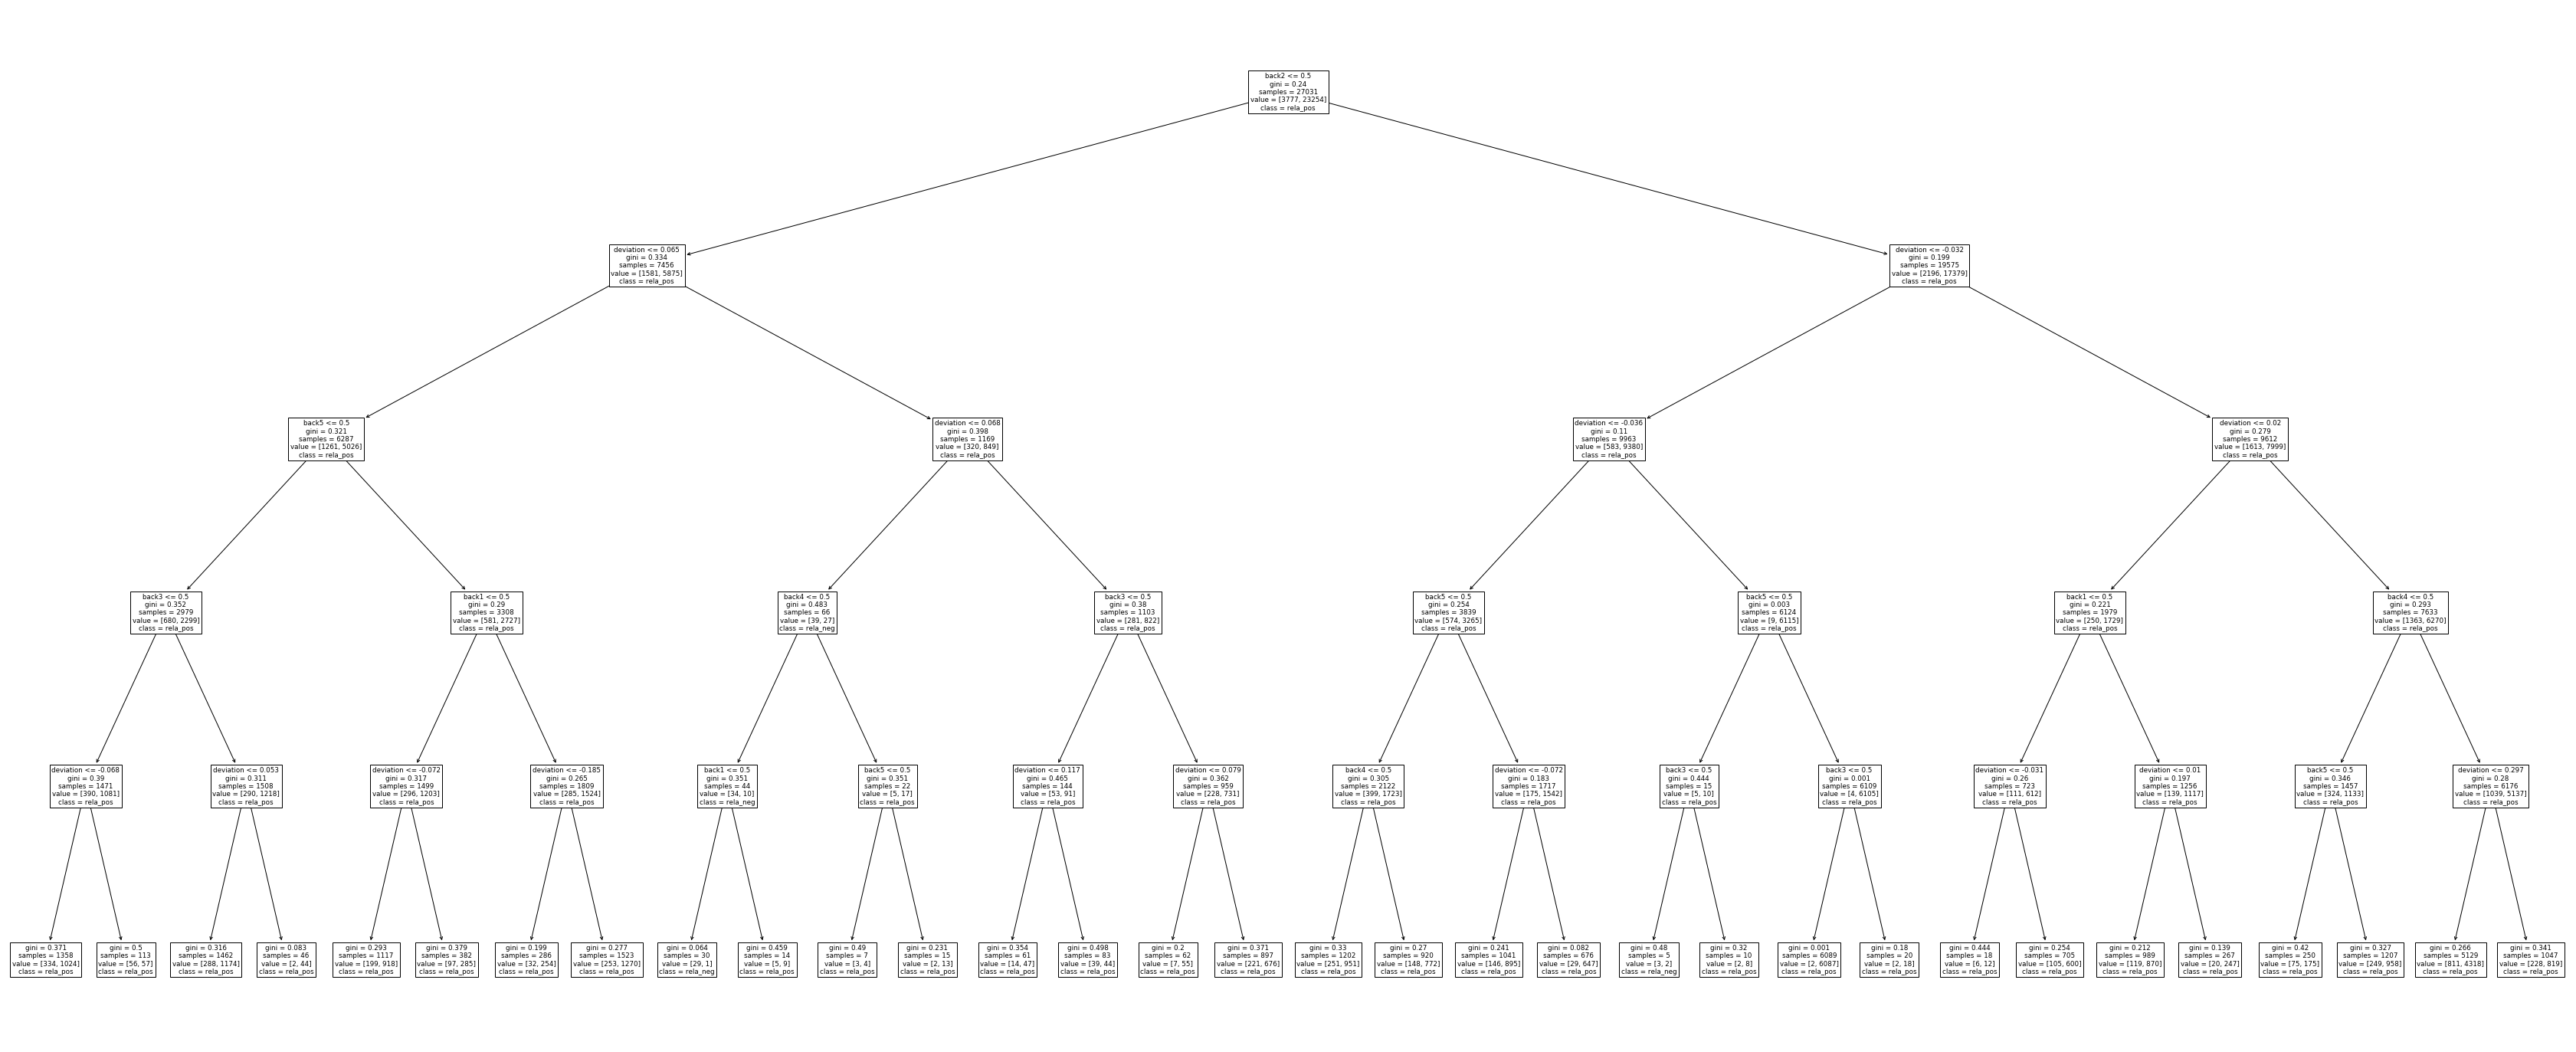

In [59]:
clf7=tree.DecisionTreeClassifier(max_depth=5)
clf7.fit(Xtrain,ytrain)
fig=plt.figure(figsize=(60,25))
ax=fig.add_subplot(1,1,1)
tree.plot_tree(clf7,ax=ax,feature_names=['back1', 'back2', 'back3', 'back4', 'back5','deviation'],class_names=['rela_neg','rela_pos'])

In [44]:
Xtrain=star_review_all[['back1', 'back2', 'back3', 'back4', 'back5','deviation']]
ytrain=star_review_all['rela_pos']

In [60]:
param_grid8={'C': [0.01,0.1,1,10,100,1000,10000]}
mytree8=LogisticRegression()
clf8=GridSearchCV(mytree8, param_grid8, cv=5,scoring='roc_auc')
clf8.fit(Xtrain,ytrain)
pd.DataFrame(clf8.cv_results_)

C:\Users\86180\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\86180\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\86180\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\86180\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\86180\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.021751,0.002347,0.003015,0.000083,0.01,{'C': 0.01},0.536845,0.601995,0.679564,0.661624,0.972848,0.690556,0.149735,7
1,0.029236,0.003845,0.003029,0.000634,0.1,{'C': 0.1},0.555786,0.623949,0.723355,0.664277,0.966225,0.706700,0.140743,6
2,0.023431,0.001262,0.002449,0.000487,1,{'C': 1},0.562160,0.627864,0.737947,0.665896,0.966225,0.712000,0.139248,5
3,0.024032,0.002336,0.002601,0.000794,10,{'C': 10},0.562925,0.628107,0.739401,0.666220,0.966225,0.712558,0.139088,1
4,0.023781,0.001202,0.002429,0.000470,100,{'C': 100},0.562929,0.628130,0.739503,0.666185,0.964901,0.712312,0.138607,4
5,0.030084,0.009331,0.003800,0.002226,1000,{'C': 1000},0.562939,0.628125,0.739515,0.666169,0.964901,0.712312,0.138607,3
6,0.035173,0.006730,0.004311,0.001718,10000,{'C': 10000},0.562932,0.628129,0.739522,0.666172,0.964901,0.712313,0.138608,2


In [46]:
mylog9=LogisticRegression(C=10).fit(Xtrain,ytrain)
mylog9.coef_

C:\Users\86180\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


array([[ 0.88260493,  0.93565244,  0.26066389,  0.81599526,  0.90498935,
        -4.1220591 ]])

In [149]:
mylog9.coef_.sum()+mylog9.intercept_

array([-1.02487384])

In [143]:
mylog9.intercept_

array([-0.70272061])

In [47]:
import re
regex=re.compile('\w*')
worddicts=[]
lenlist=[]
stemmer_snowball = SnowballStemmer('english')
list_stopWords=list(set(stopwords.words('english')))
for i in range(3):
    print('loading')
    wordlist=[]
    worddict={}
    for reviews in alldata[i]['review_body']:
        if(type(reviews)==str):
            tagword=nltk.pos_tag(nltk.word_tokenize(reviews))
            tagwords=[]
            for word,po in tagword:
                if (po=='JJ')|(po=='JJR')|(po=='JJS')|(po=='RB'):
                    tagwords.append(word)
            stemwords=[stemmer_snowball.stem(word) for word in tagwords]
            wordlist.extend(stemwords)
    cleanword=[word for word in wordlist if word not in  list_stopWords]
    for word in cleanword:
        if word in worddict:
            worddict[word]+=1
        else:
            worddict[word]=1
    worddicts.append(sorted(worddict.items(),key=lambda x:x[1],reverse=True))

loading
loading
loading


In [135]:
def discriptive(given_word,val=[0,1,2],data=alldata):
    for i in val:
        haveword=[]
        for reviews in alldata[i]['review_body']:
            if(type(reviews)==str):
                if given_word in [stemmer_snowball.stem(word) for word in nltk.word_tokenize(reviews)]:
                    haveword.append(1)
                else:
                    haveword.append(0)
            else:
                haveword.append(0)
        data[i][given_word]=haveword

In [136]:
prodtype=['hair_dryer','microwave','pacifier']

In [141]:
pd.crosstab(alldata[0]['power'],alldata[0].star_rating)

star_rating,1,2,3,4,5
power,,,,,
0,947,556,840,1785,5708
1,85,83,159,311,996


In [142]:
chi2_contingency(pd.crosstab(alldata[0]['power'],alldata[0].star_rating))

(36.26361333697655,
 2.5539500582648775e-07,
 4,
 array([[ 884.98273758,  547.96896251,  856.68387097, 1797.40680035,
         5748.9576286 ],
        [ 147.01726242,   91.03103749,  142.31612903,  298.59319965,
          955.0423714 ]]))

In [137]:
for i,worddict in enumerate(worddicts):
    print(prodtype[i])
    for word,freq in worddict:
        if freq>50:
            discriptive(word,[i])
            see_if_related=pd.crosstab(alldata[i][word],alldata[i].star_rating)
            if chi2_contingency(see_if_related)[1]<0.001:
                print(word,freq)

hair_dryer
n't 4475
great 2673
good 2140
well 1625
onli 1625
hot 1209
littl 1181
quick 962
nice 927
power 893
still 862
even 860
easi 851
first 837
last 815
dri 815
enough 637
heavi 635
best 627
low 620
new 614
fast 600
light 584
happi 580
perfect 578
fine 563
thick 553
ever 552
never 547
better 533
back 514
far 513
< 512
retract 486
pretti 480
less 457
howev 432
differ 401
short 373
big 349
loud 349
sure 340
previous 332
compact 331
quit 320
hard 318
longer 314
ago 313
second 310
almost 299
excel 278
lightweight 273
cheap 272
onc 250
super 243
bad 243
away 237
br 237
complet 229
pleas 216
warm 212
probabl 209
worth 208
smooth 198
mayb 189
heavier 180
overal 176
absolut 172
fair 168
smaller 166
disappoint 166
alreadi 162
instead 156
glad 148
larg 147
awesom 146
difficult 139
amaz 138
total 136
reason 130
rather 123
sometim 123
slight 119
often 113
conveni 113
immedi 113
due 111
bright 109
twice 104
handi 103
care 103
origin 102
wrong 101
satisfi 99
favorit 98
unfortun 98
electr 95
use 

In [53]:
worddicts[0]

[("n't", 4475),
 ('veri', 3470),
 ('great', 2673),
 ('good', 2140),
 ('well', 1625),
 ('onli', 1625),
 ('realli', 1587),
 ('much', 1414),
 ('long', 1358),
 ('also', 1230),
 ('hot', 1209),
 ('littl', 1181),
 ('high', 1129),
 ('old', 988),
 ('quick', 962),
 ('nice', 927),
 ('power', 893),
 ('still', 862),
 ('even', 860),
 ('easi', 851),
 ('first', 837),
 ('last', 815),
 ('dri', 815),
 ('small', 646),
 ('enough', 637),
 ('heavi', 635),
 ('best', 627),
 ('low', 620),
 ('new', 614),
 ('fast', 600),
 ('light', 584),
 ('happi', 580),
 ('perfect', 578),
 ('fine', 563),
 ('quiet', 557),
 ('thick', 553),
 ('ever', 552),
 ('never', 547),
 ('better', 533),
 ('back', 514),
 ('far', 513),
 ('<', 512),
 ('cool', 488),
 ('retract', 486),
 ('pretti', 480),
 ('less', 457),
 ('definit', 435),
 ('howev', 432),
 ('right', 405),
 ('differ', 401),
 ('mani', 391),
 ('alway', 388),
 ('actual', 383),
 ('cur', 375),
 ('short', 373),
 ('strong', 359),
 ('big', 349),
 ('loud', 349),
 ('hair', 343),
 ('sure', 340),

In [54]:
worddicts[1]

[("n't", 854),
 ('veri', 465),
 ('onli', 400),
 ('great', 354),
 ('new', 327),
 ('good', 322),
 ('well', 318),
 ('small', 246),
 ('old', 235),
 ('also', 215),
 ('perfect', 203),
 ('much', 202),
 ('even', 201),
 ('easi', 188),
 ('<', 186),
 ('nice', 183),
 ('realli', 183),
 ('littl', 181),
 ('still', 171),
 ('back', 149),
 ('first', 148),
 ('never', 147),
 ('oven', 136),
 ('last', 129),
 ('far', 119),
 ('fine', 113),
 ('enough', 113),
 ('right', 100),
 ('less', 98),
 ('larg', 94),
 ('turntabl', 92),
 ('ago', 91),
 ('mani', 91),
 ('big', 90),
 ('happi', 89),
 ('howev', 86),
 ('high', 85),
 ('sure', 83),
 ('long', 80),
 ('ever', 78),
 ('sever', 78),
 ('previous', 75),
 ('quick', 74),
 ('better', 73),
 ('second', 73),
 ('differ', 71),
 ('exact', 70),
 ('longer', 67),
 ('actual', 67),
 ('bad', 66),
 ('microwav', 66),
 ('abl', 65),
 ('br', 65),
 ('hard', 64),
 ('top', 64),
 ('away', 63),
 ('pretti', 61),
 ('power', 61),
 ('onc', 60),
 ('later', 60),
 ('complet', 58),
 ('probabl', 57),
 ('exp

In [55]:
worddicts[2]

[("n't", 7218),
 ('veri', 3923),
 ('great', 3823),
 ('onli', 3112),
 ('littl', 2928),
 ('easi', 2268),
 ('old', 2227),
 ('well', 2126),
 ('also', 2086),
 ('good', 2084),
 ('realli', 2076),
 ('much', 1871),
 ('first', 1410),
 ('still', 1388),
 ('even', 1382),
 ('cute', 1252),
 ('nice', 1217),
 ('perfect', 1194),
 ('back', 911),
 ('soft', 910),
 ('best', 908),
 ('enough', 891),
 ('small', 872),
 ('differ', 864),
 ('easili', 862),
 ('new', 840),
 ('hard', 814),
 ('big', 758),
 ('never', 741),
 ('<', 740),
 ('abl', 738),
 ('high', 731),
 ('better', 699),
 ('sure', 697),
 ('happi', 692),
 ('right', 659),
 ('alway', 654),
 ('howev', 646),
 ('long', 617),
 ('easier', 606),
 ('mani', 587),
 ('actual', 566),
 ('pretti', 562),
 ('definit', 545),
 ('far', 540),
 ('super', 491),
 ('pacifi', 459),
 ('favorit', 457),
 ('quick', 448),
 ('newborn', 444),
 ('ador', 440),
 ('yet', 432),
 ('comfort', 426),
 ('second', 412),
 ('onc', 411),
 ('away', 401),
 ('sever', 398),
 ('ever', 395),
 ('absolut', 392)